In [1]:
%config Completer.use_jedi = False

In [18]:
import nibabel as nib

import SimpleITK as sitk

import numpy as np 
import pandas as pd 

from skimage import io, color
from matplotlib import pyplot


import os
from scipy import ndimage
import matplotlib.pyplot as plt

from torch import nn
import torch

from torch.utils.data import DataLoader, Dataset, Sampler
import segmentation_models_pytorch as smp
from IPython.display import clear_output

import albumentations as albu

%matplotlib inline

In [3]:
directory = '/data/datasets/test_task_cmai/Brain_CT_labeling/'

segs = []
imgs = []
txts = []

for filename in os.listdir(directory):
    if filename.endswith(".gz") or filename.endswith(".nii"):
            if "seg" in filename:
                segs.append(filename)
            else:
                imgs.append(filename)
    elif filename.endswith(".txt"):
        txts.append(filename)

In [4]:
class BrainDataset(Dataset):
    
    CLASSES = [str(i + 1) for i in range(20)]
    
    def __init__(self, path, image_files, segm_files, txt_transformations,
                 classes = None,
                 augmentation=None):
        self.path = path
        self.image_files = image_files
        self.segm_files = segm_files
        self.txt_transformations = txt_transformations
        self.augmentation = augmentation
        self.imgs3D = []
        self.masks3D = []
        self.slices = []
        self.class_values = [int(cls) for cls in classes]
        
        for (img, seg, transf) in zip(self.image_files, self.segm_files, self.txt_transformations):
            try:
                image_data, seg_data = self.get_array_data(path+img, path+seg, path + transf)
                seg_data[seg_data > 10] -= 10 # 
                self.imgs3D.append(image_data)
                self.masks3D.append(seg_data)
            except:
                continue
                
            for i in range(image_data.shape[2]):
                
                slice_image = image_data[...,i]
#                 slice_image = (np.clip(slice_image, -200, 300) -36) / 16
            
                self.slices.append({
                                     "image": slice_image, #.astype(np.long), 
                                     "mask": seg_data[...,i]  #.astype(np.long)
                                    })
            
    
    def __getitem__(self, idx):
        
        if idx >= len(self.slices):
            raise IndexError("list index out of range")
            
        item = self.slices[idx]
        image, mask = item["image"], item["mask"]
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        masks = [(mask == v) for v in self.class_values]
        #mask = np.stack(masks, axis=-1).astype(np.int)
        mask= np.stack(masks, axis=-3).astype(np.int)
        
        image = (np.clip(image, -200, 300) -36) / 16

        return image.reshape(1, 512, 512).astype(np.float32), mask #.reshape(20, 512, 512).astype(np.int)
        
    def __len__(self):
        return len(self.slices)
    
    def get_array_data(self, img_path, seg_path, transf_path, visualise=False):
        
        transform = self.read_transform_txt(transf_path)
        image = sitk.ReadImage(img_path)
        seg = sitk.ReadImage(seg_path)

        rot_matrix = transform[:3, :-1]
        offset = transform[:3,-1:]

        e3d_transform = sitk.Euler3DTransform()
        e3d_transform.SetMatrix(rot_matrix.flatten())
        e3d_transform.SetTranslation(offset.reshape(3))
        e3d_transform.TransformPoint([0,0,0])

        image = sitk.Resample(image, e3d_transform, sitk.sitkNearestNeighbor, defaultPixelValue = -1024 )
        image_data = sitk.GetArrayFromImage(image)
        image_data = np.moveaxis(image_data, 0, -1)
    
        seg_data = sitk.GetArrayFromImage(seg)
        seg_data = np.moveaxis(seg_data, 0, -1)
        
        if visualise:
            slice_img = image_data[:, :, 55]
            slice_seg = seg_data[:, :, 55]
            show_slices([slice_img, slice_seg])
        
        return image_data, seg_data
    

    def read_transform_txt(self, path):

        transform = None
        with open( path, 'r' ) as f:
            for line in f:

                if line.startswith( 'Parameters:' ):
                    values = line.split( ': ' )[1].split( ' ' )
                    values = [float( e ) for e in values if ( e != '' and e != '\n' )]
                    transform_upper_left = np.reshape( values[0:9], ( 3, 3 ) )
                    translation = values[9:]


                if line.startswith( 'FixedParameters:' ):
                    values = line.split( ': ' )[1].split( ' ' )
                    values = [float( e ) for e in values if ( e != '' and e != '\n' )]
                    center = values


        offset = np.ones(4)
        for i in range(0, 3):

            offset[i] = translation[i] + center[i];

            for j in range(0, 3):

                offset[i] -= transform_upper_left[i][j] * center[i]

        transform = np.vstack((transform_upper_left, [0, 0, 0]))
        transform = np.hstack((transform, np.reshape( offset, (4, 1))))

        return transform

In [6]:
CLASSES = [str(i + 1) for i in range(10)]

In [141]:
def get_training_augmentation():
    train_transform = [
        albu.Flip(),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0, value=-1024),
        albu.Blur(blur_limit=3, p=0.9),
        albu.IAAAdditiveGaussianNoise(p=0.2),   
        
        albu.OneOf([
                albu.ElasticTransform(value=-1024, p=1.),
                albu.OpticalDistortion(value=-1024, p=1.),
                albu.GridDistortion(value=-1024, p=1.),
            ], .8),
    ]
    return albu.Compose(train_transform)

In [142]:
dataset_train = BrainDataset(directory,
                             sorted(imgs)[:-1],
                             sorted(segs)[:-1],
                             sorted(txts)[:-1],
                             augmentation = get_training_augmentation(),
                             classes=CLASSES)

dataset_validation = BrainDataset(directory,
                                  [sorted(imgs)[-1]],
                                  [sorted(segs)[-1]],
                                  [sorted(txts)[-1]],
                                  classes=CLASSES)

In [143]:
dataset_train[70][0].shape

(1, 512, 512)

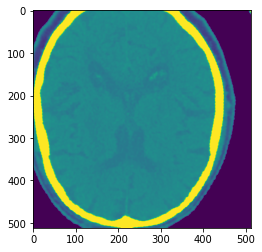

In [153]:
plt.imshow(dataset_train[70][0][0,:,:])

In [60]:
img = nib.load('/data/datasets/test_task_cmai/Brain_CT_labeling/1.nii.gz')
img_seg = nib.load('/data/datasets/test_task_cmai/Brain_CT_labeling/1-seg.nii.gz')

img_data = img.get_fdata()
img_data_arr = np.asarray(img_data)

img_seg_data = img_seg.get_fdata()
img_seg_data_arr = np.asarray(img_seg_data)

In [72]:
transform = dataset_train.read_transform_txt('/data/datasets/test_task_cmai/Brain_CT_labeling/3.txt')
image = sitk.ReadImage("/data/datasets/test_task_cmai/Brain_CT_labeling/3.nii.gz")
seg = sitk.ReadImage("/data/datasets/test_task_cmai/Brain_CT_labeling/3-seg.nii.gz")

rot_matrix = transform[:3, :-1]
offset = transform[:3,-1:]

e3d_transform = sitk.Euler3DTransform()
e3d_transform.SetMatrix(rot_matrix.flatten())
e3d_transform.SetTranslation(offset.reshape( 3))
e3d_transform.TransformPoint([0,0,0])


image = sitk.Resample(image, e3d_transform, sitk.sitkNearestNeighbor, defaultPixelValue = -1024)
image_data = sitk.GetArrayFromImage(image)
image_data = np.moveaxis(image_data, 0, -1)
    
seg_data = sitk.GetArrayFromImage(seg)
seg_data = np.moveaxis(seg_data, 0, -1)

In [114]:
img_data_arr.shape

(512, 512, 116)

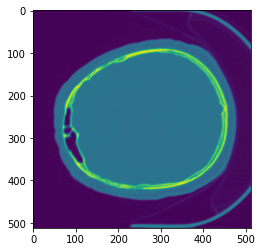

In [116]:
plt.imshow(img_data_arr[:,:,70])

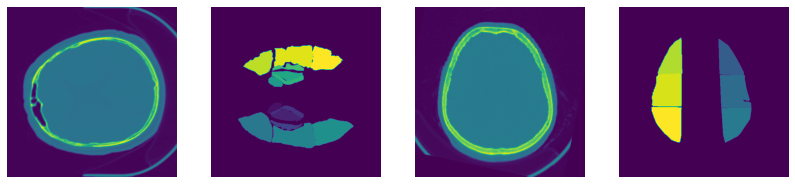

In [74]:
fig=plt.figure(figsize=(14, 14))

fig.add_subplot(1, 4, 1)
plt.axis('off')
plt.imshow(img_data_arr[:,:,70])

fig.add_subplot(1, 4, 2)
plt.axis('off')
plt.imshow(img_seg_data_arr[:,:,70])   

fig.add_subplot(1, 4, 3)
plt.axis('off')
plt.imshow(image_data[:,:,70])

fig.add_subplot(1, 4, 4)
plt.axis('off')
plt.imshow(seg_data[:,:,70])

(array([123669.,   1368.,   6797.,   7341.,  95578.,   9101.,   1261.,
           958.,   1080.,  14991.]),
 array([-14.75 , -11.625,  -8.5  ,  -5.375,  -2.25 ,   0.875,   4.   ,
          7.125,  10.25 ,  13.375,  16.5  ], dtype=float32),
 <BarContainer object of 10 artists>)

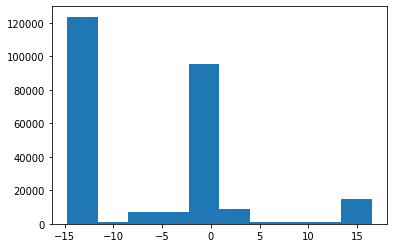

In [113]:
plt.hist(dataset_train[70][0].flatten())

In [123]:
dataset_train.imgs3D[0].shape

(512, 512, 116)

In [124]:
img_slice = dataset_train.imgs3D[0][:,:,70]

In [132]:
np.median(image_data[seg_data>0])

38.0

In [131]:
np.mean(image_data[seg_data>0])

37.35566338745046

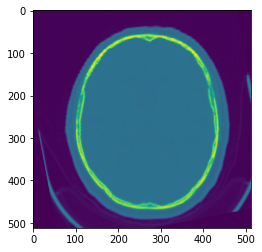

In [125]:
plt.imshow(img_slice)

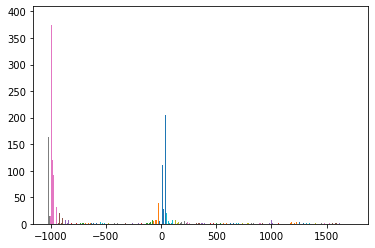

In [109]:
plt.hist(img_data_arr[:,:,70], 100);

In [81]:
ndimage.label(dataset_validation[70][1])

AttributeError: 'tuple' object has no attribute 'flatten'

In [84]:
dataset_validation[70][1].shape

(10, 512, 512)

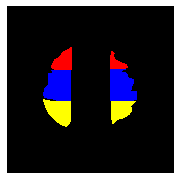

In [16]:
fig=plt.figure(figsize=(10, 10))

valid = np.argmax(dataset_validation[76][1], axis=0)
fig.add_subplot(4, 2, 2)
plt.axis('off')
io.imshow(color.label2rgb(valid, bg_label=0))

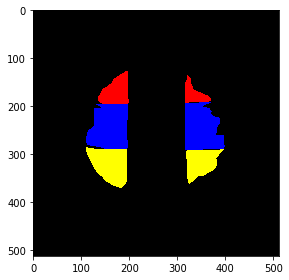

In [76]:
# valid[246] = 1000
io.imshow(color.label2rgb(valid, bg_label=0))

In [19]:
ndimage.measurements.center_of_mass(valid)

(263.49153348902246, 243.1707504557201)

In [24]:
np.unique(valid)

array([0, 4, 5, 6])

In [28]:
import numpy as np
from skimage import measure
from time import perf_counter as pc

times = [pc()]
props = measure.regionprops(valid)

for i in range(np.unique(valid).shape[0] - 1):
    print(props[i].centroid)



(170.21026225769668, 227.13409350057012)
(244.65121250092136, 251.55856121471217)
(320.3847955956425, 237.55394166569053)


In [36]:
coords = 0
for i in props:
    coords += i.centroid[1]

coord = int(coords/len(props))

238


In [ ]:
# scipy ndimage label th>0.5 => компоненты связности 
# numpy bincount от label.flatten 
# любую пар координат => вектор, основание - лев, конец - правый
# второй класс => вектор, если не сонаправлен, меняю

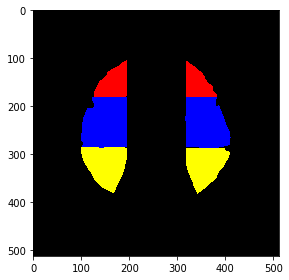

In [168]:
img = dataset_validation[70][1]
img_argmax = np.argmax(img, axis=0)
io.imshow(color.label2rgb(img_argmax, bg_label=0))

In [164]:
label = scipy.ndimage.label(dataset_validation[70][1])

In [171]:
dataset_validation.masks3D[0].shape

(512, 512, 102)

In [166]:
len(label)

2

In [162]:
np.bincount().flatten())

AttributeError: 'tuple' object has no attribute 'flatten'

In [160]:
dataset_validation[70][1]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 